# Calculate path propagation/attenuation according to ITU-R P.452 (16)

## License

```
Calculate path propagation/attenuation according to ITU-R P.452 (16).
Copyright (C) 2015+  Benjamin Winkel (bwinkel@mpifr.de)

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
```

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pycraf import pathprof
from pycraf import conversions as cnv
from astropy import units as u

## Height profiles and maps from SRTM data

With pycraf it is very easy to query SRTM data for arbitrary positions. However, you will need to have to download such SRTM data, either in advance or during your session. Please see the [documentation](https://bwinkel.github.io/pycraf/pathprof/working_with_srtm.html) for more details.

Use the following, if you already have the SRTMDATA environment variable set, but not downloaded any ".hgt" files so far.

In [3]:
# pathprof.SrtmConf.set(download='missing', server='viewpano')

If you neither have the environment variable set nor ".hgt" files downloaded (you can use any target directory, of course):

In [4]:
# pathprof.SrtmConf.set(download='missing', server='viewpano', srtm_dir='.')

### Query height profile

In [5]:
lon_t, lat_t = 6.8836 * u.deg, 50.525 * u.deg
lon_r, lat_r = 7.3334 * u.deg, 50.635 * u.deg
hprof_step = 100 * u.m  # if made large, Gaussian smoothing is applied to avoid aliasing

In [6]:
(
    lons, lats, distance, distances, heights,
    bearing, back_bearing, back_bearings
    ) = pathprof.srtm_height_profile(
        lon_t, lat_t, lon_r, lat_r, hprof_step
        )

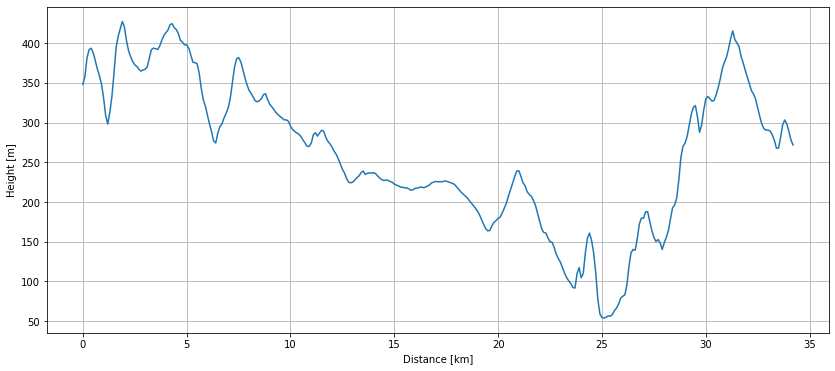

In [7]:
_distances = distances.to(u.km).value
_heights = heights.to(u.m).value

plt.close()
plt.figure(figsize=(14, 6))
plt.plot(_distances, _heights)
plt.xlabel('Distance [km]')
plt.ylabel('Height [m]')
plt.grid()
plt.show()

### Obtain terrain maps

With the same function, one could also easily obtain height maps of an area, by just feed in the desired coordinates. However, pycraf also provides a convenience function that makes it easier (make sure to provide the necessary .hgt-files):

In [8]:
# lon_t, lat_t = 6.52 * u.deg, 53.22 * u.deg  # Netherlands
lon_t, lat_t = 9.943 * u.deg, 54.773 * u.deg  # Northern Germany
map_size_lon, map_size_lat = 1.5 * u.deg, 1.5 * u.deg
map_resolution = 3. * u.arcsec

In [9]:
lons, lats, heightmap = pathprof.srtm_height_map(
    lon_t, lat_t,
    map_size_lon, map_size_lat,
    map_resolution=map_resolution,
    )


For plotting, we provide a nice colormap, to account for sea level

/home/bwinkel/local/miniconda/envs/pycraf3.7new/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/home/bwinkel/local/miniconda/envs/pycraf3.7new/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/home/bwinkel/local/miniconda/envs/pycraf3.7new/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: 
The label1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.label1.set_visible instead.
/home/bwinkel/local/miniconda/envs/pycraf3.7new/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: 
The label2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.label2.set_v

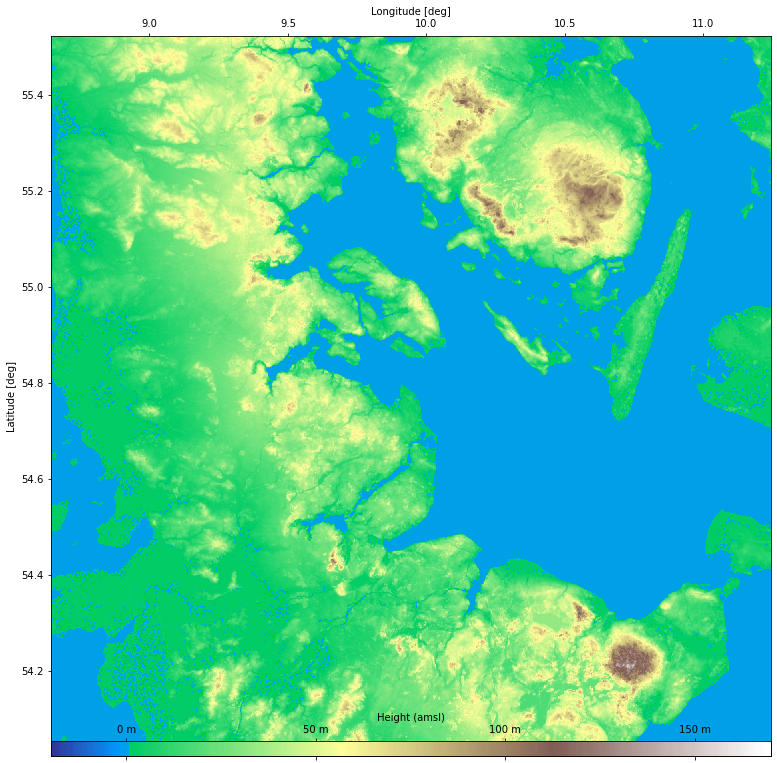

In [10]:
_lons = lons.to(u.deg).value
_lats = lats.to(u.deg).value
_heightmap = heightmap.to(u.m).value

vmin, vmax = -20, 170
terrain_cmap, terrain_norm = pathprof.terrain_cmap_factory(sealevel=0.5, vmax=vmax)
_heightmap[_heightmap < 0] = 0.51  # fix for coastal region

plt.close()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_axes((0., 0., 1.0, 1.0))
cbax = fig.add_axes((0., 0., 1.0, .02))
cim = ax.imshow(
    _heightmap,
    origin='lower', interpolation='nearest',
    cmap=terrain_cmap, norm=terrain_norm,
    vmin=vmin, vmax=vmax,
    extent=(_lons[0], _lons[-1], _lats[0], _lats[-1]),
    )
cbar = fig.colorbar(
    cim, cax=cbax, orientation='horizontal'
    )
ax.set_aspect(abs(_lons[-1] - _lons[0]) / abs(_lats[-1] - _lats[0]))
cbar.set_label(r'Height (amsl)', color='k')
cbax.xaxis.set_label_position('top')
for t in cbax.xaxis.get_major_ticks():
    t.tick1On = True
    t.tick2On = True
    t.label1On = False
    t.label2On = True
ctics = np.arange(0, 1150, 50)
cbar.set_ticks(ctics)
cbar.ax.set_xticklabels(map('{:.0f} m'.format, ctics), color='k')
ax.set_xlabel('Longitude [deg]')
ax.set_ylabel('Latitude [deg]')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()

## Path attenuation according to ITU-R P.452 (16)

Based on the height profiles, one can calculate the path attenuation between a transceiving and receiving station. There are three use cases of interest:

- Tx and Rx station are at well-known locations
- Tx station location is fixed, want to know attenuation for a region around the Tx (e.g., to find good Rx locations)
- Rx station location is fixed, want to know attenuation for a region around the Rx (e.g., to find good Tx locations)

The latter two cases are completely symmetric and in fact for the path attenuation it is not important, if Tx or Rx location is in the middle of the map.

### Case 1: Tx and Rx stations at fixed locations

To calculate path attenuation with the pycraf.pathprof module is a two-step process. First, one generates a `PathProp` object, which contains all kinds of parameters that define the path geometry and hold other necessary quantities (there are many!). Second, one feeds this object into one of the functions that calculate attenuation:

- Line-of-sight (LoS) or free-space loss: `pathprof.loss_freespace`
- Tropospheric scatter loss: `pathprof.loss_troposcatter`
- Ducting and anomalous layer refraction loss: `pathprof.loss_ducting`
- Diffraction loss: `pathprof.loss_diffraction`

Of course, there is also a function (`pathprof.loss_complete`) to calculate the total loss (a non-trivial combination of the above). As the `pathprof.loss_complete` function also returns the most important constituents, it is usually sufficient to use that. The individual functions are only provided for reasons of computing speed, if one is really only interested in one component.

In [11]:
# Create PathProp object
freq = 1. * u.GHz

lon_tx, lat_tx = 6.8836 * u.deg, 50.525 * u.deg
lon_rx, lat_rx = 7.3334 * u.deg, 50.635 * u.deg
hprof_step = 100 * u.m  # resolution of height profile

omega = 0. * u.percent  # fraction of path over sea
temperature = 290. * u.K
pressure = 1013. * u.hPa
time_percent = 2 * u.percent  # see P.452 for explanation
h_tg, h_rg = 5 * u.m, 50 * u.m
G_t, G_r = 0 * cnv.dBi, 15 * cnv.dBi

# clutter zones
zone_t, zone_r = pathprof.CLUTTER.URBAN, pathprof.CLUTTER.SUBURBAN

pprop = pathprof.PathProp(
    freq,
    temperature, pressure,
    lon_tx, lat_tx,
    lon_rx, lat_rx,
    h_tg, h_rg,
    hprof_step,
    time_percent,
    zone_t=zone_t, zone_r=zone_r,
    )

The `PathProp` object is immutable, so if you want to change something, you have to create a new instance. This is, because, many member attributes are dependent on each other and by just changing one value one could easily create inconsistencies. It is easily possible to access the parameters:

In [12]:
print(repr(pprop))

PathProp<Freq: 1.000 GHz>


In [13]:
print(pprop)

version        :           16 (P.452 version; 14 or 16)
freq           :     1.000000 GHz       
wavelen        :     0.299792 m         
polarization   :            0 (0 - horizontal, 1 - vertical)
temperature    :   290.000000 K         
pressure       :  1013.000000 hPa       
time_percent   :     2.000000 percent   
beta0          :     1.954410 percent   
omega          :     0.000000 percent   
lon_t          :     6.883600 deg       
lat_t          :    50.525000 deg       
lon_r          :     7.333400 deg       
lat_r          :    50.635000 deg       
lon_mid        :     7.108712 deg       
lat_mid        :    50.580333 deg       
delta_N        :    38.080852 dimless / km
N0             :   324.427961 dimless   
distance       :    34.128124 km        
bearing        :    68.815620 deg       
back_bearing   :  -110.836903 deg       
hprof_step     :   100.000000 m         
zone_t         :            7           
zone_r         :            5           
h_tg           :    

In [14]:
print(pprop.eps_pt, pprop.eps_pr)  # path elevation angles as seen from Tx, Rx

4.529580772837248 deg 1.883388026488473 deg


The next step is to feed the `PathProp` object into the attenuation function:

In [15]:
tot_loss = pathprof.loss_complete(pprop, G_t, G_r)
(L_b0p, L_bd, L_bs, L_ba, L_b, L_b_corr, L) = tot_loss
print('L_b0p:    {0.value:5.2f} {0.unit} - Free-space loss'.format(L_b0p))
print('L_bd:     {0.value:5.2f} {0.unit} - Basic transmission loss associated with diffraction'.format(L_bd))
print('L_bs:     {0.value:5.2f} {0.unit} - Tropospheric scatter loss'.format(L_bs))
print('L_ba:     {0.value:5.2f} {0.unit} - Ducting/layer reflection loss'.format(L_ba))
print('L_b:      {0.value:5.2f} {0.unit} - Complete path propagation loss'.format(L_b))
print('L_b_corr: {0.value:5.2f} {0.unit} - As L_b but with clutter correction'.format(L_b_corr))
print('L:        {0.value:5.2f} {0.unit} - As L_b_corr but with gain correction'.format(L))


L_b0p:    122.37 dB - Free-space loss
L_bd:     173.73 dB - Basic transmission loss associated with diffraction
L_bs:     225.76 dB - Tropospheric scatter loss
L_ba:     212.81 dB - Ducting/layer reflection loss
L_b:      173.73 dB - Complete path propagation loss
L_b_corr: 192.94 dB - As L_b but with clutter correction
L:        177.94 dB - As L_b_corr but with gain correction


Sometimes it is interesting to look at the attenuation as a function of distance (e.g., for generic studies, [see notebook](https://github.com/bwinkel/pycraf/blob/master/notebooks/03b_path_propagation_generic.ipynb)). This is easily possible via a simple for loop. Let's first get the coordinates for the path:

In [16]:
# hprof_step = 
(
    lons, lats, distance, distances, heights,
    bearing, back_bearing, back_bearings
    ) = pathprof.srtm_height_profile(
        lon_tx, lat_tx, lon_rx, lat_rx, hprof_step
        )

In [17]:
# have to avoid the first few pixels, as each profile needs to have at
# least 5 or so values for the algorithm to work

# store attenuations in a numpy record for convenience (without units!)
attens = np.zeros(
    distances.shape, 
    dtype=np.dtype([
        ('LOS', 'f8'), ('Diffraction', 'f8'), ('Troposcatter', 'f8'), 
        ('Ducting', 'f8'), ('Total', 'f8'),
        ('Total w. clutter', 'f8'), ('Total w. clutter/gain', 'f8')
        ])
    )
attens[:5] = 1000.  # dB; initialize to huge value 

for idx in range(5, len(lons)):
    lon_rx = lons[idx]
    lat_rx = lats[idx]

    pprop = pathprof.PathProp(
        freq,
        temperature, pressure,
        lon_tx, lat_tx,
        lon_rx, lat_rx,
        h_tg, h_rg,
        hprof_step,
        time_percent,
        zone_t=zone_t, zone_r=zone_r,
        )
    
    tot_loss = pathprof.loss_complete(pprop, G_t, G_r)
    attens[idx] = tuple(u.Quantity(tot_loss).value)

This takes relatively long if the path has many steps. The reason is that we extracted the full height profile for each step. But this isn't necessary, because it is basically the same for each iteration (just that needs only a subset for the nearer distances). Therefore, the `PathProp` constructor also allows to provide a height profile (otherwise, it will extract it itself). Further speed-up is possible, if also the $\Delta N$ and $N_0$ values are fixed (again, `PathProp` would infer them using a relatively slow Python routine).

In [18]:
# do the same, but much faster!

# Note, strictly, this has to be calculated for the mid-point of the path.
# However, it comes from a very low-res data base, so the errors can
# be neglected.
delta_N, N0 = pathprof.deltaN_N0_from_map(lon_tx, lat_tx)

for idx in range(5, len(lons)):
    lon_rx = lons[idx]
    lat_rx = lats[idx]

    # Note, if custom height profile is given, associated distances
    # and bearings must also be provided!
    pprop = pathprof.PathProp(
        freq,
        temperature, pressure,
        lon_tx, lat_tx,
        lon_rx, lat_rx,
        h_tg, h_rg,
        hprof_step,
        time_percent,
        zone_t=zone_t, zone_r=zone_r,
        hprof_dists=distances[:idx],
        hprof_heights=heights[:idx],
        hprof_bearing=bearing,
        hprof_backbearing=back_bearing,
        delta_N=delta_N, N0=N0,
        )
    
    tot_loss = pathprof.loss_complete(pprop, G_t, G_r)
    attens[idx] = tuple(u.Quantity(tot_loss).value)

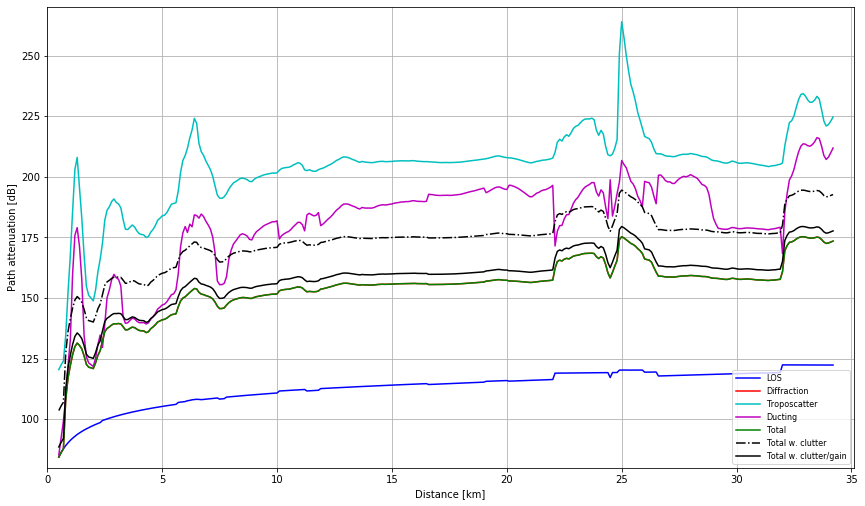

In [19]:
plt.close()
fig = plt.figure(figsize=(14, 8))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
for (name, style) in zip(
        attens.dtype.names, 
        ['b-', 'r-', 'c-', 'm-', 'g-', 'k-.', 'k-']
        ):
    ax.plot(distances[5:].to(u.km).value, attens[name][5:], style, label=name)

ax.legend(
    *ax.get_legend_handles_labels(), 
    loc='lower right', fontsize=8, handlelength=3
    )
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Path attenuation [dB]')
ax.grid()
ax.set_xlim((0, 35.1))
ax.set_ylim((80, 270))
plt.show()

Note that the wiggles in the LoS curve originate from focussing effects (this is $L_{b0p}$ and not $L_{bfsg}$! See P.452 for details.)

Since this task occurs quite often in spectrum management, pycraf even provides a parallelized (via Cython) function to do exactly this. One first calls

In [20]:
hprof_data = pathprof.height_path_data(
    lon_tx, lat_tx, lon_rx, lat_rx, hprof_step,
    zone_t=pathprof.CLUTTER.URBAN, zone_r=pathprof.CLUTTER.SUBURBAN,
    )

to create a Python dictionary containing all the necessary auxillary data. 

In [21]:
print(hprof_data.keys())

dict_keys(['lons', 'lats', 'lon_mids', 'lat_mids', 'distances', 'heights', 'bearing', 'backbearings', 'omega', 'd_tm', 'd_lm', 'd_ct', 'd_cr', 'zone_t', 'zone_r', 'delta_N', 'N0', 'beta0'])


Then we use that to directly compute the attenuations. There is one big difference to the above approach - the fast routine won't account for Tx/Rx gains. This is because in reality, one usually has to apply antenna pattern functions and consider the path horizon angles, as well.

In [22]:
results = pathprof.atten_path_fast(
    freq, temperature, pressure,
    h_tg, h_rg, time_percent,
    hprof_data,
    )

In [23]:
print(results.keys())

dict_keys(['L_b0p', 'L_bd', 'L_bs', 'L_ba', 'L_b', 'L_b_corr', 'eps_pt', 'eps_pr', 'd_lt', 'd_lr', 'path_type'])


The `eps_pt` and `eps_pr` arrays contain the path horizon angles (as seen by Tx/Rx) and could be used to compute the gain at the correct boresights. This of course also depends on the antenna looking angles. The `d_lt` and `d_lr` are the distances to the local horizon (w.r.t. Tx/Rx), or - if a LoS path - to the Bullington point (see P.452). Finally, `path_type` is an integer array that contains the type of the path, either LoS ("0") or Trans-horizon ("1").

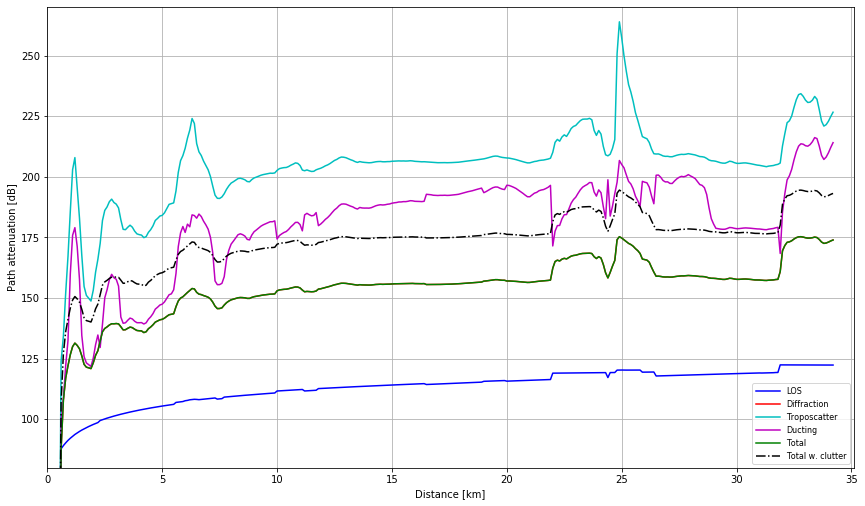

In [24]:
plt.close()
fig = plt.figure(figsize=(14, 8))
ax = fig.add_axes((0.1, 0.1, 0.8, 0.8))
for key, name, style in zip(
        ['L_b0p', 'L_bd', 'L_bs', 'L_ba', 'L_b', 'L_b_corr'],
        attens.dtype.names[:-1], 
        ['b-', 'r-', 'c-', 'm-', 'g-', 'k-.']
        ):
    ax.plot(
        hprof_data['distances'][5:],
        results[key][5:],
        style, label=name
        )

ax.legend(
    *ax.get_legend_handles_labels(), 
    loc='lower right', fontsize=8, handlelength=3
    )
ax.set_xlabel('Distance [km]')
ax.set_ylabel('Path attenuation [dB]')
ax.grid()
ax.set_xlim((0, 35.1))
ax.set_ylim((80, 270))
plt.show()